<a href="https://colab.research.google.com/github/princexoleo/malaria_cell_classification_deep_learning/blob/master/malaria_cell_classification_using_fastao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Malaria Cells Claasification : Fastai

##Import Libraires and Data from Google Drive

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
from fastai.vision import *
import pandas as pd

In [0]:
# Download and unzip the dataset from
# 'https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip'
# to PATH
PATH = "/gdrive/My Drive/Colab Notebooks/malaria"
DATAPATH = f"{PATH}/cell_images/"

In [16]:
!ls {DATAPATH}

ls: cannot access '/gdrive/My': No such file or directory
ls: cannot access 'Drive/Colab': No such file or directory
ls: cannot access 'Notebooks/malaria/cell_images/': No such file or directory


In [17]:
import os
os.listdir(DATAPATH)

['Parasitized', 'Uninfected', 'cell_images']

In [18]:
files = get_files(f'{DATAPATH}', extensions='.png', recurse=True)
len(files)

27565

In [0]:
# Get label from file_path -- folder's name
def get_label(file_path): return 'infected' if '/Parasitized/' in str(file_path) else 'clean'

In [0]:
bs=64 # Batch size
data = ImageDataBunch.from_name_func(f'{DATAPATH}', fnames=files, 
                                     label_func=get_label,      # Parasitized -> infected; Uninfected -> clean
                                     bs = bs,
                                     ds_tfms=get_transforms(), 
                                     size=170                   # resize all images
                                    ).normalize(imagenet_stats)

In [0]:
df = pd.DataFrame(data.y.items)
df['category'] = df[0].replace({0:data.classes[0], 1:data.classes[1]})

In [22]:
data

ImageDataBunch;

Train: LabelList (22052 items)
x: ImageList
Image (3, 170, 170),Image (3, 170, 170),Image (3, 170, 170),Image (3, 170, 170),Image (3, 170, 170)
y: CategoryList
infected,infected,infected,infected,infected
Path: /gdrive/My Drive/Colab Notebooks/malaria/cell_images;

Valid: LabelList (5513 items)
x: ImageList
Image (3, 170, 170),Image (3, 170, 170),Image (3, 170, 170),Image (3, 170, 170),Image (3, 170, 170)
y: CategoryList
clean,clean,infected,clean,infected
Path: /gdrive/My Drive/Colab Notebooks/malaria/cell_images;

Test: None

In [23]:
df['category'].value_counts()

infected    11042
clean       11010
Name: category, dtype: int64

In [25]:
# infected cells ratio in the dataset or sample
data.y.items.sum()/len(data.y.items)

0.5007255577725377

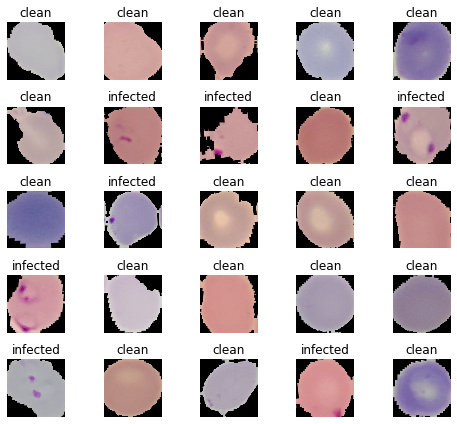

In [26]:
data.show_batch(row=3, figsize=(7,6))

##Model 1 -- ResNet-34


###Resnet-34: Stage-1 -- Trainig the last layer only

In [27]:
learn = create_cnn(data, models.resnet34, pretrained=True, metrics=accuracy)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [28]:
## model summary
learn

Learner(data=ImageDataBunch;

Train: LabelList (22052 items)
x: ImageList
Image (3, 170, 170),Image (3, 170, 170),Image (3, 170, 170),Image (3, 170, 170),Image (3, 170, 170)
y: CategoryList
infected,infected,infected,infected,infected
Path: /gdrive/My Drive/Colab Notebooks/malaria/cell_images;

Valid: LabelList (5513 items)
x: ImageList
Image (3, 170, 170),Image (3, 170, 170),Image (3, 170, 170),Image (3, 170, 170),Image (3, 170, 170)
y: CategoryList
clean,clean,infected,clean,infected
Path: /gdrive/My Drive/Colab Notebooks/malaria/cell_images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [29]:
## train
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.332876,0.200910,0.925268,2:07:09
1,0.210018,0.139820,0.953383,04:00
2,0.180365,0.121634,0.958099,03:59
3,0.160090,0.108227,0.962997,03:57
4,0.152686,0.102036,0.964448,03:57
5,0.119920,0.096183,0.965355,03:58
6,0.120080,0.093026,0.966624,03:57
7,0.134557,0.092770,0.965899,03:59


In [0]:
# save
learn.save('stage-1')

###ResNet34: Stage 1-Result Analysis

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

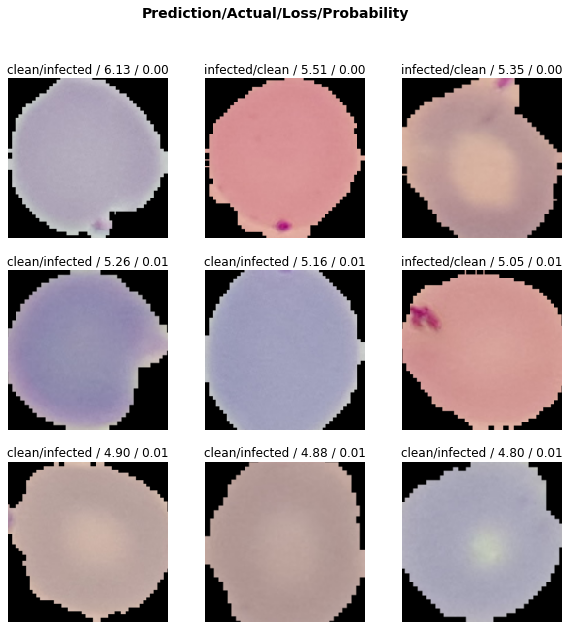

In [34]:
# plot
interp.plot_top_losses(9, figsize=(10,10))

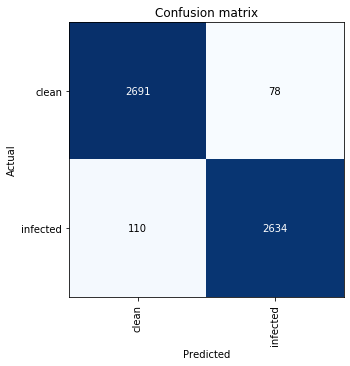

In [35]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(5,5))

In [37]:
interp.most_confused(min_val=2)

[('infected', 'clean', 110), ('clean', 'infected', 78)]

##ResNet34: Stage 2- Unfreezing all layes, fine tuning and choosing learning rate

In [0]:
# Enable all the layers of NN to learn ---> set requires_grad = True
learn.unfreeze() 

In [0]:
# learn.load('stage-1)

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
# unfreeze and train
learn.fit_one_cycle(4, max_lr=slice(le-6,le-5))

In [0]:
# save
learn.save('stage-2')

###ResNet34: stage 2 -- Result analysis

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

In [0]:
interp.plot_top_losses(9, figsize=(10,10))

In [0]:
doc(interp.plot_top_losses)

In [0]:
interp.plot_confusion_matrix(figsize=(5,5))

In [0]:
interp.most_confused(min_val=2)

##Model 2 -- ResNet-50